In [1]:
import torch
import torchvision
import helper_functions
from torchinfo import summary
import matplotlib.pyplot as plt
from torch import nn
from going_modular import data_setup
from going_modular import engine
from helper_functions import set_seeds
from helper_functions import plot_loss_curves

c:\Users\chandula\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Getting the data

data_20_percent_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [5]:
# Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"


In [6]:
# Freeze the base layers in the model
for param in effnetb2.parameters():
    param.requires_grad = False

In [7]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        False
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1408, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --           

In [8]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
# Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3))

In [10]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1408, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

Creating a function to make an EffNetB2 feature extractor

In [11]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [13]:
effnetb2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

Training EffNetB2 feature extractor

In [15]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

 10%|█         | 1/10 [00:56<08:29, 56.57s/it]

Epoch: 1 | train_loss: 0.9884 | train_acc: 0.5500 | test_loss: 0.7394 | test_acc: 0.9409


 20%|██        | 2/10 [01:42<06:44, 50.52s/it]

Epoch: 2 | train_loss: 0.7132 | train_acc: 0.8583 | test_loss: 0.5780 | test_acc: 0.9318


 30%|███       | 3/10 [02:34<05:57, 51.03s/it]

Epoch: 3 | train_loss: 0.5799 | train_acc: 0.8979 | test_loss: 0.4813 | test_acc: 0.9500


 40%|████      | 4/10 [03:34<05:27, 54.53s/it]

Epoch: 4 | train_loss: 0.4636 | train_acc: 0.8917 | test_loss: 0.4281 | test_acc: 0.9437


 50%|█████     | 5/10 [04:36<04:45, 57.18s/it]

Epoch: 5 | train_loss: 0.4290 | train_acc: 0.8917 | test_loss: 0.3893 | test_acc: 0.9443


 60%|██████    | 6/10 [05:34<03:50, 57.67s/it]

Epoch: 6 | train_loss: 0.4111 | train_acc: 0.9042 | test_loss: 0.3510 | test_acc: 0.9688


 70%|███████   | 7/10 [06:38<02:58, 59.55s/it]

Epoch: 7 | train_loss: 0.4267 | train_acc: 0.8542 | test_loss: 0.3205 | test_acc: 0.9563


 80%|████████  | 8/10 [07:32<01:55, 57.73s/it]

Epoch: 8 | train_loss: 0.4196 | train_acc: 0.8958 | test_loss: 0.3369 | test_acc: 0.9597


 90%|█████████ | 9/10 [08:27<00:57, 57.09s/it]

Epoch: 9 | train_loss: 0.3661 | train_acc: 0.8833 | test_loss: 0.3098 | test_acc: 0.9347


100%|██████████| 10/10 [09:22<00:00, 56.22s/it]

Epoch: 10 | train_loss: 0.3537 | train_acc: 0.8688 | test_loss: 0.2787 | test_acc: 0.9563


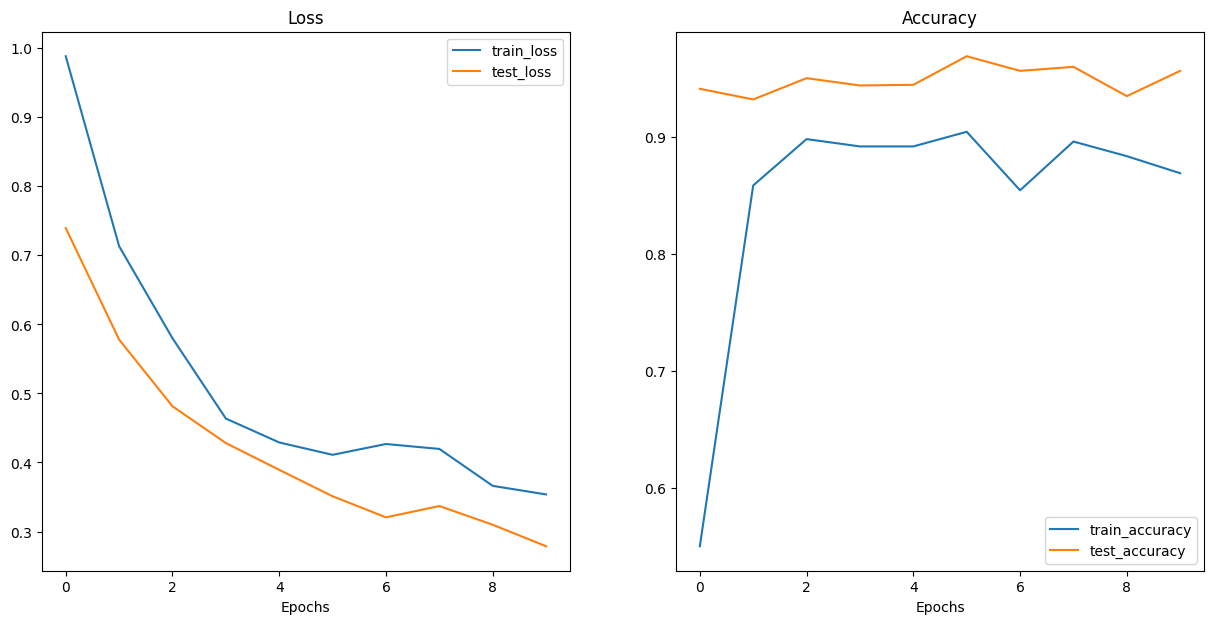

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)